## This notebook contains application of a few classification algorithms such as <font color='palevioletred'>LogisticRegression, LGBMClassifier, RandomForestClassifier and Support Vector Classifier</font> to distinguish the Positive class i.e., IL-5 inducing peptides from the Negative Class i.e., IL-5 non-inducing peptides, on the basis of various Amino acid composition features generated for the peptide sequences.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight 

from sklearn.feature_selection import RFE
from sklearn.metrics import *

import tqdm
import warnings
warnings.filterwarnings('ignore')

/home/harsheen/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Loading the Data

In [2]:
df = pd.read_csv('../../Data/final_df.csv')

In [3]:
df

,Sequence,Qualitative_Measure,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,...,QSO1_G_R,QSO1_G_S,QSO1_G_T,QSO1_G_V,QSO1_G_W,QSO1_G_Y,QSO1_SC1,QSO1_G1,SOC1_SC1,SOC1_G1
0,DRAHYNIVTFCCKCD,Positive,6.67,20.00,13.33,0.00,6.67,0.00,6.67,6.67,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3610,0.3610,0.4035,17303.9286
1,MHGDTPTLHEYM,Positive,0.00,0.00,8.33,8.33,0.00,8.33,16.67,0.00,...,0.0000,0.0000,0.0003,0.0000,0.0000,0.0001,0.3086,0.3086,0.4057,6560.6364
2,DSTLRLCVQSTHVD,Positive,0.00,7.14,14.29,0.00,0.00,0.00,7.14,0.00,...,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000,0.3301,0.3301,0.3790,12500.1538
3,RNGYRALMDKSLHVGTQCALTRR,Positive,8.70,4.35,4.35,0.00,0.00,8.70,4.35,0.00,...,0.0002,0.0000,0.0001,0.0000,0.0000,0.0000,0.4485,0.4485,0.3696,11510.5000
4,SYVLEGTLTAEKTTLVVKEG,Positive,5.00,0.00,0.00,15.00,0.00,10.00,0.00,0.00,...,0.0000,0.0001,0.0003,0.0002,0.0000,0.0001,0.3506,0.3506,0.2842,6816.4211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11420,AFMGYALPWGQMSFWGATVI,Negative,15.00,0.00,0.00,0.00,10.00,15.00,0.00,5.00,...,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.3390,0.3390,0.2699,12955.8947
11421,QKLAPISIMYQISPPLNVSL,Positive,5.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,...,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.2657,0.2657,0.1904,11019.8421
11422,SCSPTFSSDPLTTPPLMLTT,Negative,0.00,5.00,5.00,0.00,5.00,0.00,0.00,0.00,...,0.0000,0.0003,0.0004,0.0000,0.0000,0.0000,0.2045,0.2045,0.1353,6345.3158
11423,PLPWALQTTNLPLMAMSSLL,Positive,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0000,0.0001,0.0001,0.0000,0.0001,0.0000,0.2224,0.2224,0.1505,9836.7895


In [4]:
df.drop(columns = 'Sequence', inplace=True)

In [5]:
df

,Qualitative_Measure,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,QSO1_G_R,QSO1_G_S,QSO1_G_T,QSO1_G_V,QSO1_G_W,QSO1_G_Y,QSO1_SC1,QSO1_G1,SOC1_SC1,SOC1_G1
0,Positive,6.67,20.00,13.33,0.00,6.67,0.00,6.67,6.67,6.67,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3610,0.3610,0.4035,17303.9286
1,Positive,0.00,0.00,8.33,8.33,0.00,8.33,16.67,0.00,0.00,...,0.0000,0.0000,0.0003,0.0000,0.0000,0.0001,0.3086,0.3086,0.4057,6560.6364
2,Positive,0.00,7.14,14.29,0.00,0.00,0.00,7.14,0.00,0.00,...,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000,0.3301,0.3301,0.3790,12500.1538
3,Positive,8.70,4.35,4.35,0.00,0.00,8.70,4.35,0.00,4.35,...,0.0002,0.0000,0.0001,0.0000,0.0000,0.0000,0.4485,0.4485,0.3696,11510.5000
4,Positive,5.00,0.00,0.00,15.00,0.00,10.00,0.00,0.00,10.00,...,0.0000,0.0001,0.0003,0.0002,0.0000,0.0001,0.3506,0.3506,0.2842,6816.4211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11420,Negative,15.00,0.00,0.00,0.00,10.00,15.00,0.00,5.00,0.00,...,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.3390,0.3390,0.2699,12955.8947
11421,Positive,5.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,5.00,...,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.2657,0.2657,0.1904,11019.8421
11422,Negative,0.00,5.00,5.00,0.00,5.00,0.00,0.00,0.00,0.00,...,0.0000,0.0003,0.0004,0.0000,0.0000,0.0000,0.2045,0.2045,0.1353,6345.3158
11423,Positive,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0000,0.0001,0.0001,0.0000,0.0001,0.0000,0.2224,0.2224,0.1505,9836.7895


We have 9190 composition based features. This is an incredibly large number of dimensions and in such high dimensional space, machine learning algorithms can easily overfit, and also processing high dimensional datasets is a computationally heavy task. Literature evidences suggest that not all features carry importance with respect to class prediction and hence we can reduce the dimensionality by dropping the unimportant features.
For this purpose we shall use **Recursive Feature Elimination(RFE)**.

## Recursive Feature Elimination

In [6]:
def get_data(X, y, scale=False):
    idx = X.index
    
    y = y.loc[idx]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if scale:
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns) # since scalers output numpy arrays hence to get df
        X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [14]:
# function to determine the performance of a model during each iteration of RFE
def feature_drop_scorer(rfe, X, y, model):
    max_rank = np.max(rfe.ranking_)  
    mean_scores_train = []
    std_scores_train = []  
    mean_scores_val = []
    std_scores_val = []
    
    oversampler = SMOTE(random_state=42)
    
    for i in tqdm.tqdm(range(max_rank+1, 1, -1)):  
        split = StratifiedKFold(n_splits=5)

        scores_train = []
        scores_val = []
        scores_test = []
        for train_idx, val_idx in split.split(X,y): 
            temp = X.loc[:, rfe.ranking_ < i]  
            X_tr, y_tr = temp.iloc[train_idx], y.iloc[train_idx]
            X_tr, y_tr = oversampler.fit_resample(X_tr, y_tr)
            X_val, y_val = temp.iloc[val_idx], y.iloc[val_idx]

            model.fit(X_tr, y_tr)
            scores_val.append(matthews_corrcoef(y_val, model.predict(X_val)))
            scores_train.append(matthews_corrcoef(y_tr, model.predict(X_tr)))            
        

        mean_score_train = np.mean(scores_train)
        std_score_train = np.std(scores_train)
        mean_scores_train.append(mean_score_train)
        std_scores_train.append(std_score_train)
        
        mean_score_val = np.mean(scores_val)
        std_score_val = np.std(scores_val)
        mean_scores_val.append(mean_score_val)
        std_scores_val.append(std_score_val)
        
    return mean_scores_train, std_scores_train, mean_scores_val, std_scores_val

In [8]:
def get_features(rfe, X, features_required):
    max_rank = np.max(rfe.ranking_)
    for i in range(max_rank+1, 1, -1):
        cols = X.loc[:, rfe.ranking_ < i].columns
        if len(cols) == features_required:
            return cols
        
    return 'Please enter a valid feature number as per combination searched.'

### Upsampling using SMOTE()

In [9]:
df['Qualitative_Measure'].value_counts()  

Negative    8676
Positive    2749
Name: Qualitative_Measure, dtype: int64

We can see that there is a large difference in the number of samples for the Negative and Positive Class, thus we are dealing with a clear case of class imbalance. Thus before dropping features we need to balance our classes to prevent the model in rfe from overfitting to and analysing the feature importance according to the majority class.

In [10]:
# using getdata() to generate our data
X_train, X_test, y_train, y_test = get_data(df.drop(columns='Qualitative_Measure'), df['Qualitative_Measure'], scale=True)

In [11]:
# oversampling X_train using SMOTE()
oversampler = SMOTE(random_state=42)

X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

In [12]:
y_train.value_counts() # imbalanced

Negative    6941
Positive    2199
Name: Qualitative_Measure, dtype: int64

In [13]:
y_train_os.value_counts() # now balanced

Negative    6941
Positive    6941
Name: Qualitative_Measure, dtype: int64

In [15]:
rfe = RFE(estimator = LogisticRegression(), n_features_to_select=300, step=150, verbose=1)

rfe.fit(X_train_os, y_train_os)

Fitting estimator with 9189 features.
Fitting estimator with 9039 features.
Fitting estimator with 8889 features.
Fitting estimator with 8739 features.
Fitting estimator with 8589 features.
Fitting estimator with 8439 features.
Fitting estimator with 8289 features.
Fitting estimator with 8139 features.
Fitting estimator with 7989 features.
Fitting estimator with 7839 features.
Fitting estimator with 7689 features.
Fitting estimator with 7539 features.
Fitting estimator with 7389 features.
Fitting estimator with 7239 features.
Fitting estimator with 7089 features.
Fitting estimator with 6939 features.
Fitting estimator with 6789 features.
Fitting estimator with 6639 features.
Fitting estimator with 6489 features.
Fitting estimator with 6339 features.
Fitting estimator with 6189 features.
Fitting estimator with 6039 features.
Fitting estimator with 5889 features.
Fitting estimator with 5739 features.
Fitting estimator with 5589 features.
Fitting estimator with 5439 features.
Fitting esti

RFE(estimator=LogisticRegression(), n_features_to_select=300, step=150,
    verbose=1)

In [17]:
logreg = LogisticRegression()

mean_scores_train, std_scores_train, mean_scores_val, std_scores_val = feature_drop_scorer(rfe, X_train, y_train, logreg)

100%|█████████████████████████████████████████| 61/61 [1:30:10<00:00, 88.69s/it]


In [18]:
np.unique(rfe.ranking_)[-1]

61

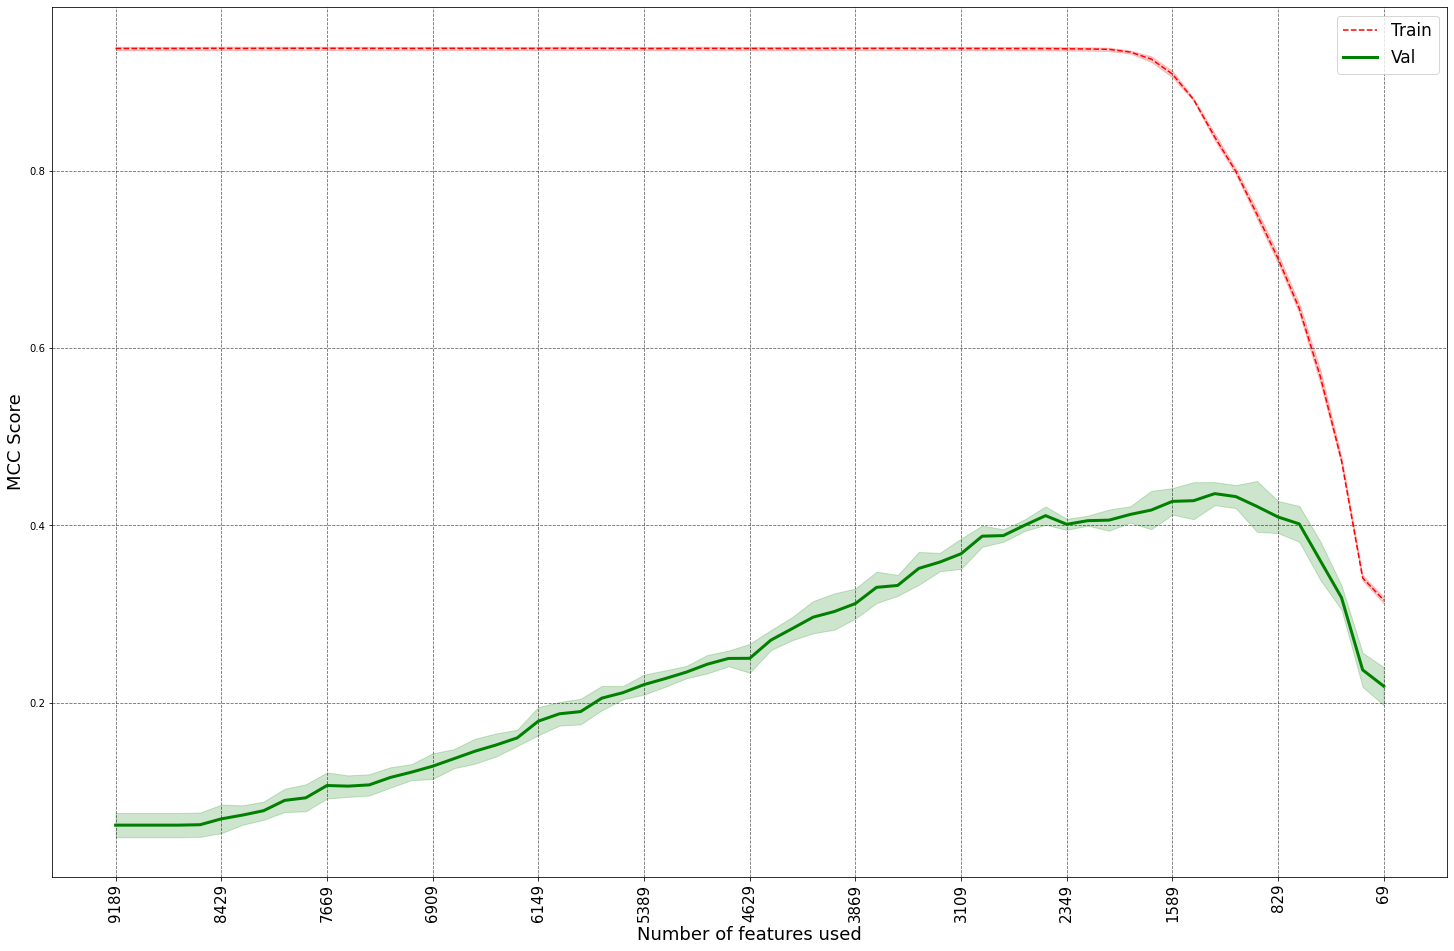

In [19]:
upper_bound_train = np.array(mean_scores_train) + np.array(std_scores_train)
lower_bound_train = np.array(mean_scores_train) - np.array(std_scores_train)
upper_bound_val = np.array(mean_scores_val) + np.array(std_scores_val)
lower_bound_val = np.array(mean_scores_val) - np.array(std_scores_val)

plt.figure(figsize=(25, 16))
plt.plot(mean_scores_train, label='Train', color='r', linewidth=1.5, linestyle='--')
plt.plot(mean_scores_val, label='Val', color='g', linewidth=3)
plt.fill_between(range(0, np.unique(rfe.ranking_)[-1], 1), y1=lower_bound_train, y2=upper_bound_train, alpha=0.2, color='r')
plt.fill_between(range(0, np.unique(rfe.ranking_)[-1], 1), y1=lower_bound_val, y2=upper_bound_val, alpha=0.2, color='g')
plt.grid(alpha=0.6, color='k', linestyle='--')
plt.xticks(ticks=range(0, np.unique(rfe.ranking_)[-1], 5), labels=range(len(X_train.columns), 0, -760), rotation=90, fontsize=15)
plt.ylabel('MCC Score', fontsize=18)
plt.xlabel('Number of features used', fontsize=18)
plt.legend(fontsize=17)
plt.show()

According to the figure, we can see that the training MCC score remains constant till around 1900 features when the training score starts dropping, i.e., the features that were being dropped are probably not informative and hence donot affect the training score, but after 1900 features, the score starts dropping probably because now, the informative features have started getting dropped.

As for the validation mcc score, that remains very low as compared, but we observe a constant increase till a maximum of approx. 0.45 at some 1100 features, probably because of the decrease in the dimensions.

After 829 features however we see a drop even in the validation mcc score because of loss of informative features.

I will be selecting to work with 1089 features. At this number, the training score has come down a bit but the performance on the validation dataset remains high, representing the point of generalised performance.

In [20]:
# selecting the desired number of features
features_to_use = get_features(rfe,X_train_os,1089)

In [21]:
features_to_use

Index(['DPC1_AG', 'DPC1_AI', 'DPC1_AK', 'DPC1_AT', 'DPC1_CT', 'DPC1_DR',
       'DPC1_EA', 'DPC1_EK', 'DPC1_FK', 'DPC1_GR',
       ...
       'CeTD_25_p_VW1', 'CeTD_50_p_HB2', 'CeTD_25_p_VW2', 'CeTD_25_p_SS2',
       'CeTD_50_p_SA2', 'CeTD_25_p_HB3', 'CeTD_50_p_PZ3', 'CeTD_50_p_SS3',
       'QSO1_SC_G', 'QSO1_G_T'],
      dtype='object', length=1089)

## Preparing the data

In [22]:
# original dataset
df

,Qualitative_Measure,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,...,QSO1_G_R,QSO1_G_S,QSO1_G_T,QSO1_G_V,QSO1_G_W,QSO1_G_Y,QSO1_SC1,QSO1_G1,SOC1_SC1,SOC1_G1
0,Positive,6.67,20.00,13.33,0.00,6.67,0.00,6.67,6.67,6.67,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3610,0.3610,0.4035,17303.9286
1,Positive,0.00,0.00,8.33,8.33,0.00,8.33,16.67,0.00,0.00,...,0.0000,0.0000,0.0003,0.0000,0.0000,0.0001,0.3086,0.3086,0.4057,6560.6364
2,Positive,0.00,7.14,14.29,0.00,0.00,0.00,7.14,0.00,0.00,...,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000,0.3301,0.3301,0.3790,12500.1538
3,Positive,8.70,4.35,4.35,0.00,0.00,8.70,4.35,0.00,4.35,...,0.0002,0.0000,0.0001,0.0000,0.0000,0.0000,0.4485,0.4485,0.3696,11510.5000
4,Positive,5.00,0.00,0.00,15.00,0.00,10.00,0.00,0.00,10.00,...,0.0000,0.0001,0.0003,0.0002,0.0000,0.0001,0.3506,0.3506,0.2842,6816.4211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11420,Negative,15.00,0.00,0.00,0.00,10.00,15.00,0.00,5.00,0.00,...,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.3390,0.3390,0.2699,12955.8947
11421,Positive,5.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,5.00,...,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.2657,0.2657,0.1904,11019.8421
11422,Negative,0.00,5.00,5.00,0.00,5.00,0.00,0.00,0.00,0.00,...,0.0000,0.0003,0.0004,0.0000,0.0000,0.0000,0.2045,0.2045,0.1353,6345.3158
11423,Positive,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0000,0.0001,0.0001,0.0000,0.0001,0.0000,0.2224,0.2224,0.1505,9836.7895


In [23]:
# using the selected features to determine the features to be dropped
features_to_drop = [i for i in df.columns if i not in features_to_use and i != 'Qualitative_Measure']

In [114]:
#save it so that we can use them anytime
# with open('../../Data/features-to-drop_.txt', 'w') as file:
#     for i in features_to_drop:
#         line = i
#         file.writelines(line+'\n')

In [24]:
# dropping features
df_red = df.drop(columns=features_to_drop)
df_red

,Qualitative_Measure,DPC1_AG,DPC1_AI,DPC1_AK,DPC1_AT,DPC1_CT,DPC1_DR,DPC1_EA,DPC1_EK,DPC1_FK,...,CeTD_25_p_VW1,CeTD_50_p_HB2,CeTD_25_p_VW2,CeTD_25_p_SS2,CeTD_50_p_SA2,CeTD_25_p_HB3,CeTD_50_p_PZ3,CeTD_50_p_SS3,QSO1_SC_G,QSO1_G_T
0,Positive,0.0,0.0,0.0,0.00,0.0,7.14,0.0,0.00,0.0,...,1,1,1,0,5,0,1,2,0.0000,0.0000
1,Positive,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,...,1,2,1,0,5,0,1,1,0.6914,0.0003
2,Positive,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,...,1,2,1,0,5,0,2,2,0.0000,0.0001
3,Positive,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,...,2,3,2,1,8,0,2,4,1.1030,0.0001
4,Positive,0.0,0.0,0.0,0.00,0.0,0.00,0.0,5.26,0.0,...,2,4,1,0,7,0,1,2,1.2988,0.0003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11420,Negative,0.0,0.0,0.0,5.26,0.0,0.00,0.0,0.00,0.0,...,2,4,0,0,10,0,2,0,1.9830,0.0000
11421,Positive,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,...,2,3,1,0,9,0,3,2,0.0000,0.0000
11422,Negative,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,...,3,6,0,0,9,0,4,0,0.0000,0.0004
11423,Positive,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,...,2,4,0,0,10,0,3,1,0.0000,0.0001


In [115]:
# df_red.to_csv('../../Data/rfe_df_1090.csv', index=False)

In [25]:
# we will make our own scorer function to use in grid search cv
def matthews_correlation(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    mcc = (tp*tn - fp*fn) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5
    
    return mcc

mcc = make_scorer(matthews_correlation, greater_is_better=True)

In [26]:
X = df_red.drop(columns = 'Qualitative_Measure')
y = df_red['Qualitative_Measure']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [27]:
# upsampling to remove imbalance in the dataset
oversampler = SMOTE(random_state=42)
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train) 

In [28]:
X_train_os.shape, y_train_os.shape, X_test.shape, y_test.shape

((13882, 1089), (13882,), (2285, 1089), (2285,))

### 1. Logistic Regression

In [36]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_os)
X_test_scaled = scaler.transform(X_test)

In [37]:
param_grid_lr = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]}

logreg = LogisticRegression(max_iter=1000)

stratified_fold = StratifiedKFold()

gridlr = GridSearchCV(logreg, param_grid_lr, cv = stratified_fold, n_jobs=-1, scoring=mcc, return_train_score=True)

gridlr.fit(X_train_scaled, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7,
                               1]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [38]:
pd.DataFrame(gridlr.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
5,{'C': 0.3},0.695082,0.599288
6,{'C': 0.5},0.694469,0.599150
4,{'C': 0.1},0.694122,0.598729
7,{'C': 0.7},0.693983,0.598254
3,{'C': 0.01},0.690469,0.598210
8,{'C': 1},0.694045,0.598097
2,{'C': 0.001},0.656416,0.576217
1,{'C': 0.0001},0.593881,0.525309
0,{'C': 1e-05},0.553152,0.487634


In [39]:
modellr = gridlr.best_estimator_

### Evaluating the Performance
* `Confusion matrix` to look at the number of TN,FN,TP,FP
* `Accuracy`
* `Precision` and `Recall(Sensitivity/True Positive Rate)`
*  `Specificity`
* `AU ROC`
* `AU PRC`
* `MCC` : Since I have an imbalanced dataset thus I will be considering Matthews correlation coefficient as the most important scoring metrics to judge any model's performance

#### 1.1 Default prediction threshold of 0.5

In [40]:
y_test.value_counts()

Negative    1735
Positive     550
Name: Qualitative_Measure, dtype: int64

In [41]:
# Confusion Matrix
confusion_matrix(y_test, modellr.predict(X_test_scaled))

array([[1350,  385],
       [ 259,  291]])

[[TN, FP], 
[FN, TP]] 
 
The first row is of Total Negatives and the second is of Total Positives;  This we can also confirm by summing up the first row, 1350(tn) + 385(fp) = 1735 (total negatives)

So, out of the 550 positives the model predicts 291 as true positives and 259 as false negatives.

In [42]:
# Accuracy
print(f"The training score for the model is : {modellr.score(X_train_scaled, y_train)*100:.2f}%")
print(f"The testing score for the model is : {modellr.score(X_test_scaled, y_test)*100:.2f}%")

The training score for the model is : 84.17%
The testing score for the model is : 71.82%


In [43]:
# Precision/PPV
precision_score(y_test, modellr.predict(X_test_scaled), pos_label='Positive')

0.43047337278106507

In [44]:
# Recall / Sensitivity / TPR
recall_score(y_test, modellr.predict(X_test_scaled), pos_label="Positive")

0.5290909090909091

In [45]:
# F1 score
f1_score(y_test, modellr.predict(X_test_scaled), pos_label="Positive")

0.4747145187601957

In [46]:
# Specificity / TNR
tn, fp, fn, tp = confusion_matrix(y_test, modellr.predict(X_test_scaled)).ravel()

Specificity = tn / (tn + fp)
Specificity

0.7780979827089337

In [47]:
# NPV
npv = tn / (tn + fn)
npv

0.839030453697949

The AUC-PRC is 0.48535680539172443


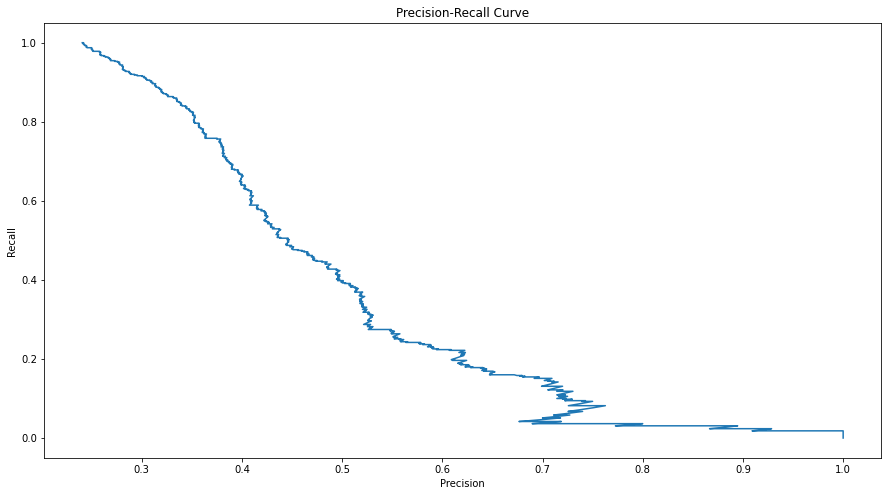

In [48]:
# AU-PRC 
precision, recall, threshold = precision_recall_curve(y_test, modellr.decision_function(X_test_scaled), pos_label='Positive')

plt.figure(figsize=(15,8))
plt.plot(precision, recall, label = 'precision recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')

print(f"The AUC-PRC is {average_precision_score(y_test, modellr.decision_function(X_test_scaled), pos_label='Positive')}")

Best Threshold=0.242530
The AU-ROC is 0.7354817919832329


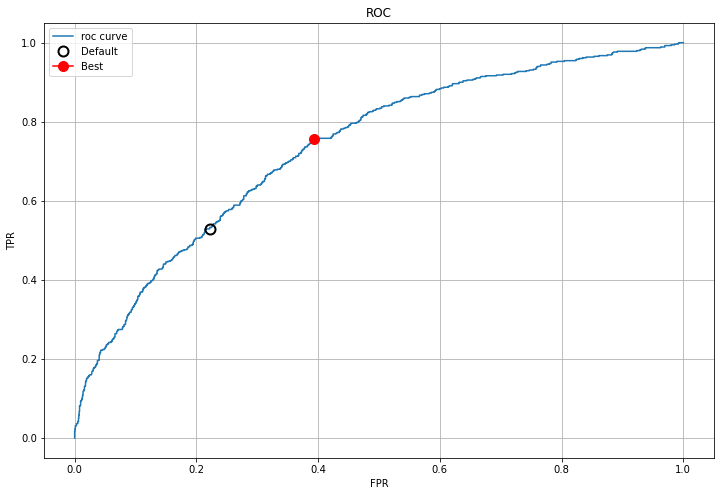

In [49]:
# AU-ROC
fpr, tpr, thresholds = roc_curve(y_test, modellr.predict_proba(X_test_scaled)[:,1], pos_label='Positive')

plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label = 'roc curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')

# find threshold closest to 0.5 ; Default threshold
default_thresh = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[default_thresh], tpr[default_thresh], 'o', markersize=10, 
         label="Default", fillstyle="none", c='k', mew=2)

# finding the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plt.plot(fpr[ix], tpr[ix], marker='o', markersize=10, color='red', label='Best')

print(f"The AU-ROC is {roc_auc_score(y_test, modellr.predict_proba(X_test_scaled)[:,1])}")

plt.legend()
plt.grid()

In [50]:
# MCC 
matthews_corrcoef(y_test, modellr.predict(X_test_scaled))

0.28773005020662246

The MCC score is quite low and way less than the cross validation scores received on training and validation dataset. This is a clear case of overfitting which is unresolvable. This is because as observed in the EDA notebook, these features lack distinguishing information and hence the model is fitting to noise in the training dataset. But we will continue to explore.

#### 1.2 Selecting the best threshold

In [53]:
threshold_list = np.arange(0,1.05,0.05)

In [176]:
# mapping the classes to 0 and 1 so that it is consistent with the model output
y_train_mapped = y_train_os.map({'Negative':0, 'Positive':1})
y_train_mapped

0        0
1        0
2        1
3        0
4        0
        ..
13877    1
13878    1
13879    1
13880    1
13881    1
Name: Qualitative_Measure, Length: 13882, dtype: int64

In [178]:
y_test_mapped = y_test.map({"Negative":0, "Positive":1})
y_test_mapped

9477    1
5286    0
4722    0
4331    0
6174    0
       ..
6304    1
7556    0
6602    0
203     1
5979    0
Name: Qualitative_Measure, Length: 2285, dtype: int64

In [57]:
# creating performance metrics dataframe on Training dataset at all prediction thresholds 
# for logistic regression
threshold_list = np.arange(0,1.05,0.05)
metrics = []
for i in threshold_list:
    y_preds = (modellr.predict_proba(X_train_scaled)[:,1] > i).astype("float")
    tn, fp, fn, tp = confusion_matrix(y_train_mapped, y_preds).ravel()
    sens = recall_score(y_train_mapped, y_preds)
    spec = tn / (tn + fp)
    acc = accuracy_score(y_train_mapped, y_preds)
    prec = precision_score(y_train_mapped, y_preds)
    npv = tn / (tn + fn)
    mcc = matthews_corrcoef(y_train_mapped, y_preds)
    metrics.append([sens,spec,acc,prec,npv,mcc])
logreg_metrics = pd.DataFrame(metrics, index=threshold_list, columns= ['Sens/Recall', 'Spec', 'Accuracy', 'precision/PPV', 'npv', 'mcc'])

In [58]:
logreg_metrics.index.name = 'Threshold'

In [59]:
logreg_metrics

,Sens/Recall,Spec,Accuracy,precision/PPV,npv,mcc
Threshold,,,,,,
0.00,1.000000,0.000000,0.500000,0.500000,NaN,0.000000
0.05,0.993949,0.400375,0.697162,0.623723,0.985112,0.489977
0.10,0.986601,0.484656,0.735629,0.656882,0.973098,0.544870
0.15,0.978245,0.551217,0.764731,0.685512,0.962032,0.585534
0.20,0.969025,0.601786,0.785406,0.708746,0.951047,0.613692
0.25,0.957931,0.646449,0.802190,0.730419,0.938899,0.636021
0.30,0.945253,0.684051,0.814652,0.749486,0.925897,0.651937
0.35,0.929405,0.718196,0.823801,0.767337,0.910502,0.662548
0.40,0.910964,0.751909,0.831436,0.785954,0.894124,0.671420


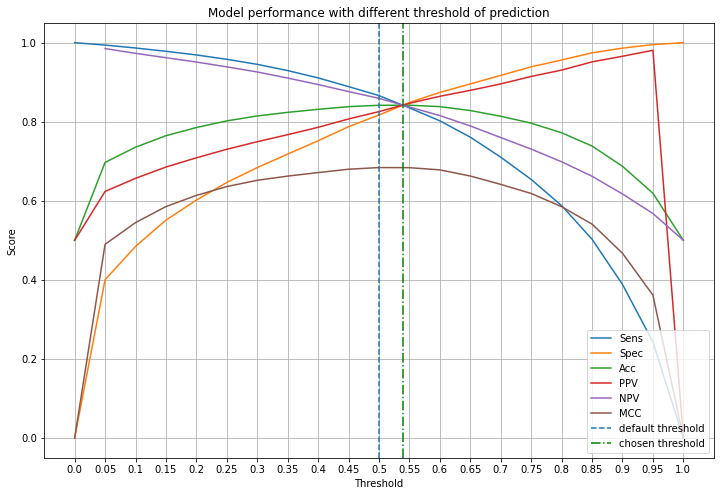

In [61]:
plt.figure(figsize=(12,8))
plt.plot(logreg_metrics.index, logreg_metrics['Sens/Recall'], label='Sens')
plt.plot(logreg_metrics.index, logreg_metrics['Spec'], label='Spec')
plt.plot(logreg_metrics.index, logreg_metrics['Accuracy'], label='Acc')
plt.plot(logreg_metrics.index, logreg_metrics['precision/PPV'], label='PPV')
plt.plot(logreg_metrics.index, logreg_metrics['npv'], label='NPV')
plt.plot(logreg_metrics.index, logreg_metrics['mcc'], label='MCC')
plt.xticks(logreg_metrics.index, np.round(threshold_list,2))
plt.axvline(x = 0.5, linestyle='--', label = 'default threshold')
plt.axvline(x = 0.54, linestyle='-.', label = 'chosen threshold', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Model performance with different threshold of prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()

From the above plot, we can infer that the model can give a better training performance wrt almost all the metrics at the threshold value of 0.54, but, we can still try to check the testing performance at all the thresholds to compare.

In [62]:
# function to create metrics dataframe at all thresholds from 0-1
def metrics_df(model, X_train, X_test, y_train_mapped, y_test_mapped):
    threshold_list = np.arange(0,1.05,0.05)
    metrics = []
    for i in threshold_list:
        y_preds_tr = (model.predict_proba(X_train)[:,1] > i).astype("float")
        y_preds_ts = (model.predict_proba(X_test)[:,1] > i).astype("float")
        tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train_mapped, y_preds_tr).ravel()
        tn_ts, fp_ts, fn_ts, tp_ts = confusion_matrix(y_test_mapped, y_preds_ts).ravel()
        sens_tr = recall_score(y_train_mapped, y_preds_tr)
        sens_ts = recall_score(y_test_mapped, y_preds_ts)
        spec_tr = tn_tr / (tn_tr + fp_tr)
        spec_ts = tn_ts / (tn_ts + fp_ts)
        acc_tr = accuracy_score(y_train_mapped, y_preds_tr)
        acc_ts = accuracy_score(y_test_mapped, y_preds_ts)
        prec_tr = precision_score(y_train_mapped, y_preds_tr)
        prec_ts = precision_score(y_test_mapped, y_preds_ts)
        npv_tr = tn_tr / (tn_tr + fn_tr)
        npv_ts = tn_ts / (tn_ts + fn_ts)
        mcc_tr = matthews_corrcoef(y_train_mapped, y_preds_tr)
        mcc_ts = matthews_corrcoef(y_test_mapped, y_preds_ts)
        metrics.append([sens_tr,sens_ts,spec_tr,spec_ts,acc_tr,acc_ts,prec_tr,prec_ts,npv_tr,npv_ts,mcc_tr,mcc_ts])
    model_metrics = pd.DataFrame(metrics, index=threshold_list, columns= ['Sens/Recall_train','Sens/Recall_test', 
                                                                       'Spec_train', 'Spec_test', 
                                                                       'Accuracy_train','Accuracy_test',
                                                                       'precision/PPV_train', 'precision/PPV_test',
                                                                       'npv_train','npv_test',
                                                                       'mcc_train','mcc_test'])
    model_metrics.index.name = 'Threshold'
    return model_metrics

In [63]:
logreg_metrics = metrics_df(modellr, X_train_scaled, X_test_scaled, y_train_mapped, y_test_mapped)
logreg_metrics

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.240700,0.500000,0.240700,NaN,NaN,0.000000,0.000000
0.05,0.993949,0.892727,0.400375,0.379251,0.697162,0.502845,0.623723,0.313138,0.985112,0.917713,0.489977,0.250572
0.10,0.986601,0.852727,0.484656,0.464553,0.735629,0.557987,0.656882,0.335479,0.973098,0.908681,0.544870,0.278329
0.15,0.978245,0.816364,0.551217,0.525648,0.764731,0.595624,0.685512,0.352987,0.962032,0.900296,0.585534,0.294323
0.20,0.969025,0.772727,0.601786,0.567147,0.785406,0.616630,0.708746,0.361395,0.951047,0.887286,0.613692,0.290723
0.25,0.957931,0.745455,0.646449,0.613833,0.802190,0.645514,0.730419,0.379630,0.938899,0.883817,0.636021,0.307658
0.30,0.945253,0.696364,0.684051,0.653026,0.814652,0.663457,0.749486,0.388832,0.925897,0.871538,0.651937,0.301614
0.35,0.929405,0.665455,0.718196,0.683573,0.823801,0.679212,0.767337,0.400000,0.910502,0.865693,0.662548,0.304523
0.40,0.910964,0.620000,0.751909,0.716427,0.831436,0.693217,0.785954,0.409364,0.894124,0.856061,0.671420,0.298824


Although we recieve the best training performance at the prediction threshold of 0.55 but the best testing performance is recieved at threshold value of 0.35.

This is probably because at this low threshold, more of the samples are predicted to be positive, thus increasing the number of true and false positives.

### 2. LightGBM
#### 2.1 with default parameters

In [153]:
# This time instead of building model on a balanced dataset 
# calculating class weights so that more weight is given to the positive classes
classes = np.unique(y_train.to_numpy())
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{'Negative': 0.6584065696585506, 'Positive': 2.078217371532515}

In [180]:
# building model with default parameters
lgb = LGBMClassifier(objective='binary')

lgb.fit(X_train_os, y_train_os)

LGBMClassifier(objective='binary')

The AUC-PRC is 0.3657591432384071


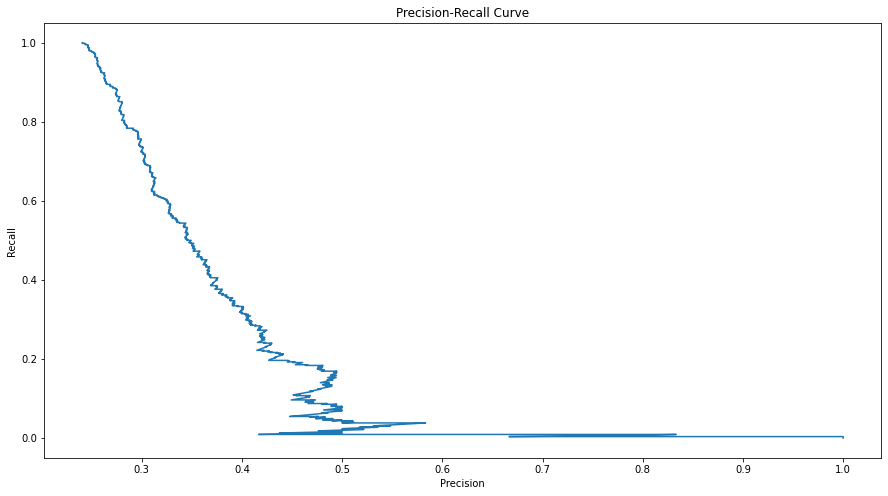

In [182]:
# AU-PRC 
precision, recall, threshold = precision_recall_curve(y_test, lgb.predict_proba(X_test)[:,1], pos_label='Positive')

plt.figure(figsize=(15,8))
plt.plot(precision, recall, label = 'precision recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')

print(f"The AUC-PRC is {average_precision_score(y_test, lgb.predict_proba(X_test)[:,1], pos_label='Positive')}")

The AU-ROC is 0.6441084621430443


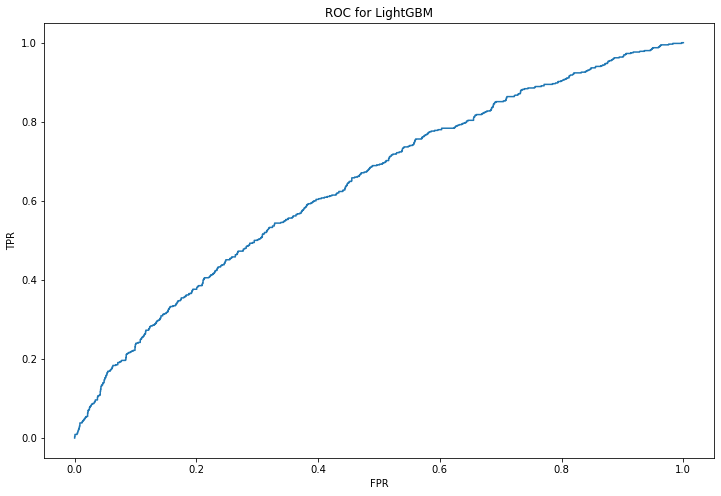

In [183]:
# AU-ROC
fpr, tpr, threshold = roc_curve(y_test, lgb.predict_proba(X_test)[:,1], pos_label="Positive")

plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label = 'ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC for LightGBM')

print(f"The AU-ROC is {roc_auc_score(y_test, lgb.predict_proba(X_test)[:,1])}")

Let's calculate the other metrices at all the possible thresholds.

In [185]:
# checking training and testing performance at all threshold
y_train_mapped_ = y_train.map({"Negative":0, "Positive":1})
y_test_mapped_ = y_test.map({"Negative":0, "Positive":1})

lgb_metrics = metrics_df(lgb, X_train_os, X_test, y_train_mapped, y_test_mapped)
lgb_metrics

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.240700,0.500000,0.240700,NaN,NaN,0.000000,0.000000
0.05,1.000000,0.996364,0.019306,0.017867,0.509653,0.253392,0.504873,0.243339,1.000000,0.939394,0.098726,0.050995
0.10,0.999712,0.967273,0.117130,0.097983,0.558421,0.307221,0.531032,0.253696,0.997546,0.904255,0.248516,0.101524
0.15,0.996830,0.889091,0.308889,0.243228,0.652860,0.398687,0.590560,0.271365,0.989843,0.873706,0.421237,0.138548
0.20,0.984584,0.745455,0.546751,0.442651,0.765668,0.515536,0.684770,0.297749,0.972578,0.845815,0.590993,0.164333
0.25,0.957787,0.570909,0.730586,0.627666,0.844187,0.614004,0.780465,0.327083,0.945377,0.821887,0.706859,0.171993
0.30,0.913989,0.412727,0.848725,0.773487,0.881357,0.686652,0.857993,0.366129,0.907984,0.806006,0.764344,0.179036
0.35,0.871056,0.332727,0.911684,0.842075,0.891370,0.719475,0.907944,0.400438,0.876090,0.799234,0.783387,0.186824
0.40,0.833886,0.256364,0.940066,0.887032,0.886976,0.735230,0.932946,0.418398,0.849831,0.790041,0.778352,0.172885


We recieve the best performance of mcc=0.18 at the default threshold of 0.35



**2.2 Building LGB with parameter tuning**

In [170]:
lgb = LGBMClassifier(objective='binary')

stratifed_fold = StratifiedKFold()

param_grid = {'n_estimators':[100,200,300],
              'learning_rate': [0.01, 0.05, 0.1, 0.3],
              'num_leaves':[20,31,50,80,100]}

gridlgb = GridSearchCV(lgb, param_grid, scoring=mcc, n_jobs=-1, cv=stratifed_fold,return_train_score=True)

gridlgb.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LGBMClassifier(objective='binary'), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [20, 31, 50, 80, 100]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [171]:
pd.DataFrame(gridlgb.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

,params,mean_train_score,mean_test_score
20,"{'learning_rate': 0.05, 'n_estimators': 200, '...",0.753574,0.691563
15,"{'learning_rate': 0.05, 'n_estimators': 100, '...",0.726353,0.689961
30,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.753305,0.689149
25,"{'learning_rate': 0.05, 'n_estimators': 300, '...",0.774775,0.687031
16,"{'learning_rate': 0.05, 'n_estimators': 100, '...",0.744025,0.686365
21,"{'learning_rate': 0.05, 'n_estimators': 200, '...",0.783285,0.684632
12,"{'learning_rate': 0.01, 'n_estimators': 300, '...",0.743782,0.684476
17,"{'learning_rate': 0.05, 'n_estimators': 100, '...",0.774170,0.683790
11,"{'learning_rate': 0.01, 'n_estimators': 300, '...",0.723390,0.683186
31,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.783310,0.682721


In [172]:
final_lgb = gridlgb.best_estimator_

In [179]:
# evaluating model performance
metrics_df(final_lgb, X_train_os, X_test, y_train_mapped, y_test_mapped)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.240700,0.500000,0.240700,NaN,NaN,0.000000,0.000000
0.05,1.000000,1.000000,0.004034,0.003458,0.502017,0.243326,0.501011,0.241334,1.000000,1.000000,0.044956,0.028889
0.10,0.999856,0.987273,0.053018,0.053026,0.526437,0.277899,0.513580,0.248399,0.997290,0.929293,0.164353,0.084621
0.15,0.997551,0.923636,0.191615,0.163112,0.594583,0.346171,0.552373,0.259184,0.987379,0.870769,0.319535,0.106176
0.20,0.983432,0.792727,0.429621,0.351585,0.706526,0.457768,0.632916,0.279308,0.962867,0.842541,0.496075,0.132606
0.25,0.942083,0.612727,0.668636,0.585591,0.805359,0.592123,0.739790,0.319129,0.920286,0.826688,0.634918,0.170053
0.30,0.887912,0.434545,0.826394,0.766571,0.857153,0.686652,0.836455,0.371118,0.880565,0.810481,0.715662,0.191109
0.35,0.840945,0.329091,0.903904,0.855908,0.872425,0.729103,0.897448,0.419954,0.850366,0.800971,0.746330,0.202165
0.40,0.803487,0.258182,0.938193,0.900865,0.870840,0.746171,0.928571,0.452229,0.826816,0.792998,0.748502,0.197491


prediction threshold of 0.35 seems to be giving the best testing mcc of 0.20, and there is an improvement in the performance as compared lgb with default parameters.

### 3. RandomForestClassifier

In [186]:
param_grid_rfc = {'n_estimators': [100, 200, 300, 400, 500, 600, 1000],
                 'max_depth': [3,5,7],
                 'max_features': [0.5, 0.6, 0.7, 0.8, 0.9]}

stratified_fold = StratifiedKFold()

rfc = RandomForestClassifier()

gridrfc = GridSearchCV(rfc, param_grid_rfc, cv = stratified_fold, n_jobs = -1, scoring=mcc, return_train_score = True)

gridrfc.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 1000]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [187]:
pd.DataFrame(gridrfc.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
72,"{'max_depth': 7, 'max_features': 0.5, 'n_estim...",0.702971,0.660930
74,"{'max_depth': 7, 'max_features': 0.5, 'n_estim...",0.702281,0.659297
75,"{'max_depth': 7, 'max_features': 0.5, 'n_estim...",0.702575,0.659186
76,"{'max_depth': 7, 'max_features': 0.5, 'n_estim...",0.703684,0.657708
73,"{'max_depth': 7, 'max_features': 0.5, 'n_estim...",0.703178,0.657638
...,...,...,...
28,"{'max_depth': 3, 'max_features': 0.9, 'n_estim...",0.475826,0.447925
18,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.486729,0.445179
22,"{'max_depth': 3, 'max_features': 0.8, 'n_estim...",0.484631,0.443615
24,"{'max_depth': 3, 'max_features': 0.8, 'n_estim...",0.482312,0.441772


In [188]:
# saving the best model
modelrfc = gridrfc.best_estimator_

The AUC-PRC is 0.32259118738015835


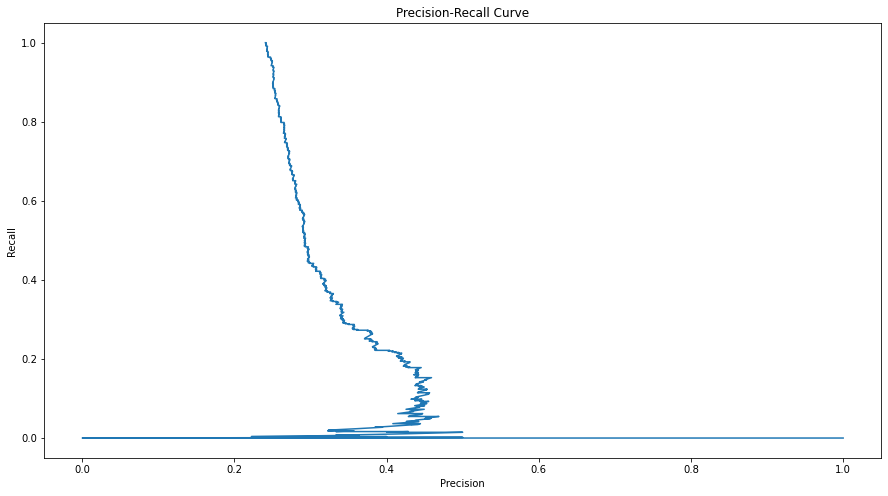

In [190]:
# AU-PRC 
precision, recall, threshold = precision_recall_curve(y_test, modelrfc.predict_proba(X_test)[:,1], pos_label='Positive')

plt.figure(figsize=(15,8))
plt.plot(precision, recall, label = 'precision recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')

print(f"The AUC-PRC is {average_precision_score(y_test, modelrfc.predict_proba(X_test)[:,1], pos_label='Positive')}")

The AU-ROC is 0.5918291852239979


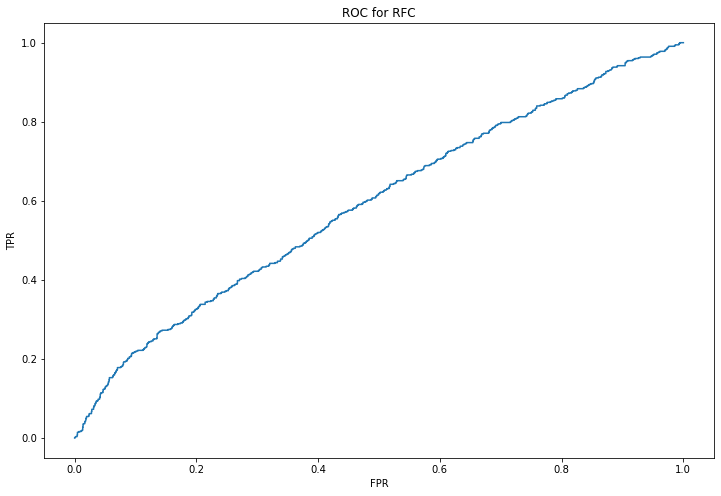

In [191]:
# AU-ROC
fpr, tpr, threshold = roc_curve(y_test, modelrfc.predict_proba(X_test)[:,1], pos_label="Positive")

plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label = 'ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC for RFC')

print(f"The AU-ROC is {roc_auc_score(y_test, modelrfc.predict_proba(X_test)[:,1])}")

**RFC seems to be making almost making almost random predictions**

In [192]:
# for all the other metrics
metrics_df(modelrfc, X_train_os, X_test, y_train_mapped, y_test_mapped)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.240700,0.500000,0.240700,NaN,NaN,0.000000,0.000000
0.05,1.000000,1.000000,0.000000,0.000000,0.500000,0.240700,0.500000,0.240700,NaN,NaN,0.000000,0.000000
0.10,1.000000,1.000000,0.000000,0.000000,0.500000,0.240700,0.500000,0.240700,NaN,NaN,0.000000,0.000000
0.15,0.999856,0.994545,0.015560,0.008646,0.507708,0.245952,0.503884,0.241288,0.990826,0.833333,0.087329,0.015431
0.20,0.999280,0.974545,0.049272,0.040922,0.524276,0.265646,0.512449,0.243636,0.985591,0.835294,0.155502,0.034941
0.25,0.993805,0.927273,0.138165,0.125072,0.565985,0.318162,0.535559,0.251479,0.957086,0.844358,0.254979,0.070828
0.30,0.967872,0.785455,0.341305,0.311239,0.654589,0.425383,0.595040,0.265519,0.913966,0.820669,0.396703,0.091290
0.35,0.900447,0.550909,0.615185,0.573487,0.757816,0.568053,0.700594,0.290508,0.860714,0.801127,0.537985,0.106766
0.40,0.806224,0.298182,0.857513,0.818444,0.831869,0.693217,0.849810,0.342380,0.815678,0.786268,0.664612,0.122489


We get the best test mcc = 0.14 at the prediction threshold of 0.45

### 4. SupportVectorClassifier

In [130]:
# converting the dataframe into sparse matrix in order to train SVC faster
X_train_sparse = sparse.csr_matrix(X_train.values)
X_test_sparse = sparse.csr_matrix(X_test.values)

In [135]:
# scaling
scaler = StandardScaler(with_mean=False)

X_train_sp_scaled = scaler.fit_transform(X_train_sparse)
X_test_sp_scaled = scaler.transform(X_test_sparse)

In [137]:
# building the model
param_gridSVC = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}

svc = SVC(probability = True)

gridsvm = GridSearchCV(svc, param_gridSVC, cv = stratified_fold, n_jobs=-1, scoring=mcc, return_train_score=True)

gridsvm.fit(X_train_sp_scaled, y_train)

/tmp/ipykernel_56321/3282180975.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_56321/3282180975.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_56321/3282180975.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_56321/3282180975.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_56321/3282180975.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_56321/3282180975.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_56321/3282180975.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_56321/3282180975.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_56321/3282180975.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_56321/3282180975.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_56321/3282180975.py:5: RuntimeWarni

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [138]:
# checking the cv results
pd.DataFrame(gridsvm.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
24,"{'C': 10, 'gamma': 0.001}",0.860242,0.670707
30,"{'C': 100, 'gamma': 0.001}",0.919022,0.661126
18,"{'C': 1, 'gamma': 0.001}",0.769913,0.639574
25,"{'C': 10, 'gamma': 0.01}",0.938212,0.629783
31,"{'C': 100, 'gamma': 0.01}",0.943183,0.620582
19,"{'C': 1, 'gamma': 0.01}",0.896819,0.603669
12,"{'C': 0.1, 'gamma': 0.001}",0.449502,0.409523
26,"{'C': 10, 'gamma': 0.1}",0.943345,0.405007
32,"{'C': 100, 'gamma': 0.1}",0.943706,0.404195
20,"{'C': 1, 'gamma': 0.1}",0.941080,0.389674


We got the above warnings as for a few of the parameter combinations the MCC score came out to be NaN.

In [139]:
# saving the best estimator
modelsvm = gridsvm.best_estimator_

The AUC-PRC is 0.35754763009695223


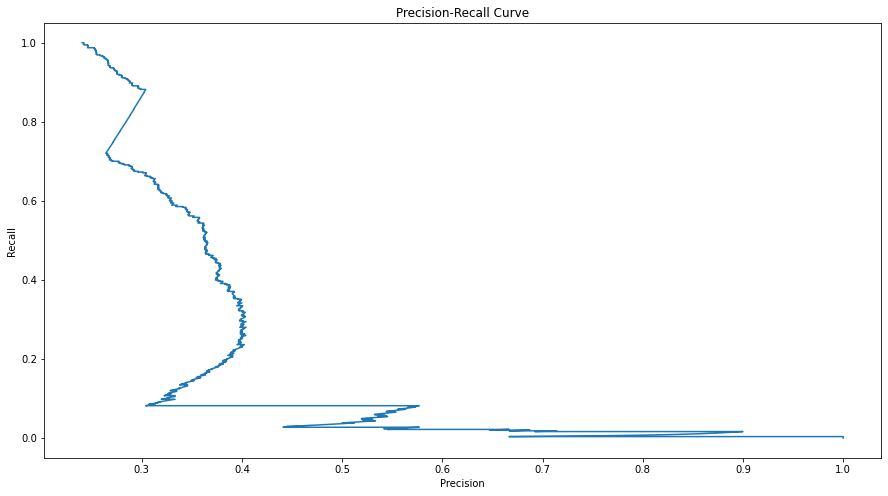

In [143]:
# AU-PRC 
precision, recall, threshold = precision_recall_curve(y_test, modelsvm.predict_proba(X_test_sp_scaled)[:,1], pos_label='Positive')

plt.figure(figsize=(15,8))
plt.plot(precision, recall, label = 'precision recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')

print(f"The AUC-PRC is {average_precision_score(y_test, modelsvm.predict_proba(X_test_sp_scaled)[:,1], pos_label='Positive')}")

The AU-ROC is 0.6458239455069427


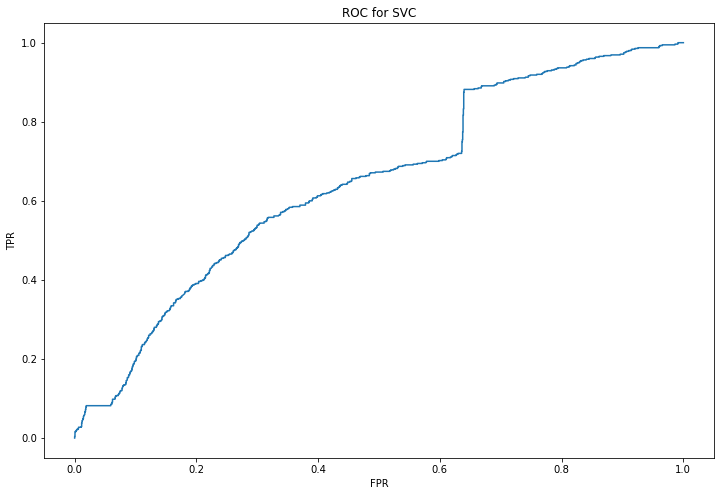

In [145]:
# AU-ROC
fpr, tpr, threshold = roc_curve(y_test, modelsvm.predict_proba(X_test_sp_scaled)[:,1], pos_label="Positive")

plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label = 'ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC for SVC')

print(f"The AU-ROC is {roc_auc_score(y_test, modelsvm.predict_proba(X_test_sp_scaled)[:,1])}")

In [141]:
metrics_df(modelsvm, X_train_sp_scaled, X_test_sp_scaled, y_train, y_test)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.240700,0.500000,0.240700,NaN,NaN,0.000000,0.000000
0.05,0.998703,0.961818,0.153292,0.144669,0.575998,0.341357,0.541182,0.262792,0.991612,0.922794,0.284574,0.140579
0.10,0.996830,0.881818,0.361619,0.346974,0.679225,0.475711,0.609604,0.299753,0.991311,0.902549,0.464110,0.215140
0.15,0.988906,0.632727,0.804351,0.567147,0.896629,0.582932,0.834833,0.316652,0.986396,0.829680,0.807122,0.171020
0.20,0.983000,0.580000,0.824521,0.648991,0.903760,0.632385,0.848526,0.343750,0.979798,0.829772,0.817856,0.199336
0.25,0.977381,0.538182,0.842386,0.699712,0.909883,0.660832,0.861132,0.362301,0.973851,0.826975,0.827340,0.212197
0.30,0.971762,0.492727,0.857801,0.729107,0.914782,0.672210,0.872349,0.365722,0.968130,0.819301,0.835003,0.202594
0.35,0.966143,0.456364,0.870624,0.755620,0.918384,0.683589,0.881904,0.371852,0.962568,0.814286,0.840611,0.198640
0.40,0.960380,0.420000,0.885895,0.778674,0.923138,0.692341,0.893805,0.375610,0.957192,0.808982,0.848633,0.191504


### In order to validate the poor performance of various models on the test dataset we can perform RFE again, but this time visualise performance on Test Dataset as well

In [29]:
# adding the test dataset as well this time
# to check the effect of recursively eliminating the features on test dataset performance
def feature_drop_scorer(rfe, X, y, X_test, y_test, model):
    max_rank = np.max(rfe.ranking_)  
    mean_scores_train = []
    std_scores_train = []  
    mean_scores_val = []
    std_scores_val = []
    mean_scores_test = []
    std_scores_test = []
    oversampler = SMOTE(random_state=42)
    
    for i in tqdm.tqdm(range(max_rank+1, 1, -1)):  
        split = StratifiedKFold(n_splits=5)

        scores_train = []
        scores_val = []
        scores_test = []
        for train_idx, val_idx in split.split(X,y): 
            temp = X.loc[:, rfe.ranking_ < i]  
            temp_test = X_test.loc[:, rfe.ranking_ < i]
            X_tr, y_tr = temp.iloc[train_idx], y.iloc[train_idx]
            X_tr, y_tr = oversampler.fit_resample(X_tr, y_tr)
            X_val, y_val = temp.iloc[val_idx], y.iloc[val_idx]

            model.fit(X_tr, y_tr)
            scores_val.append(matthews_corrcoef(y_val, model.predict(X_val)))
            scores_train.append(matthews_corrcoef(y_tr, model.predict(X_tr)))
            scores_test.append(matthews_corrcoef(y_test, model.predict(temp_test)))
            
        

        mean_score_train = np.mean(scores_train)
        std_score_train = np.std(scores_train)
        mean_scores_train.append(mean_score_train)
        std_scores_train.append(std_score_train)
        
        mean_score_val = np.mean(scores_val)
        std_score_val = np.std(scores_val)
        mean_scores_val.append(mean_score_val)
        std_scores_val.append(std_score_val)
        
        mean_score_test = np.mean(scores_test)
        std_score_test = np.std(scores_test)
        mean_scores_test.append(mean_score_test)
        std_scores_test.append(std_score_test)
        
    return mean_scores_train, std_scores_train, mean_scores_val, std_scores_val, mean_scores_test, std_scores_test

In [33]:
# using get_data() to 
X_train, X_test, y_train, y_test = get_data(df.drop(columns='Qualitative_Measure'), df['Qualitative_Measure'], scale=True)

In [34]:
# oversampling for balancing
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

In [39]:
# performing Recursive Feature Elimination
rfe = RFE(estimator = LogisticRegression(), n_features_to_select=300, step=150, verbose=1)

rfe.fit(X_train_os, y_train_os)

Fitting estimator with 9189 features.
Fitting estimator with 9039 features.
Fitting estimator with 8889 features.
Fitting estimator with 8739 features.
Fitting estimator with 8589 features.
Fitting estimator with 8439 features.
Fitting estimator with 8289 features.
Fitting estimator with 8139 features.
Fitting estimator with 7989 features.
Fitting estimator with 7839 features.
Fitting estimator with 7689 features.
Fitting estimator with 7539 features.
Fitting estimator with 7389 features.
Fitting estimator with 7239 features.
Fitting estimator with 7089 features.
Fitting estimator with 6939 features.
Fitting estimator with 6789 features.
Fitting estimator with 6639 features.
Fitting estimator with 6489 features.
Fitting estimator with 6339 features.
Fitting estimator with 6189 features.
Fitting estimator with 6039 features.
Fitting estimator with 5889 features.
Fitting estimator with 5739 features.
Fitting estimator with 5589 features.
Fitting estimator with 5439 features.
Fitting esti

RFE(estimator=LogisticRegression(), n_features_to_select=300, step=150,
    verbose=1)

In [40]:
# determining the performance during each feature drop in RFE
logreg = LogisticRegression()

mean_scores_train, std_scores_train, mean_scores_val, std_scores_val, mean_scores_test, std_scores_test = feature_drop_scorer(rfe, X_train, y_train, X_test, y_test, logreg)

100%|███████████████████████████████████████████| 61/61 [21:18<00:00, 20.96s/it]


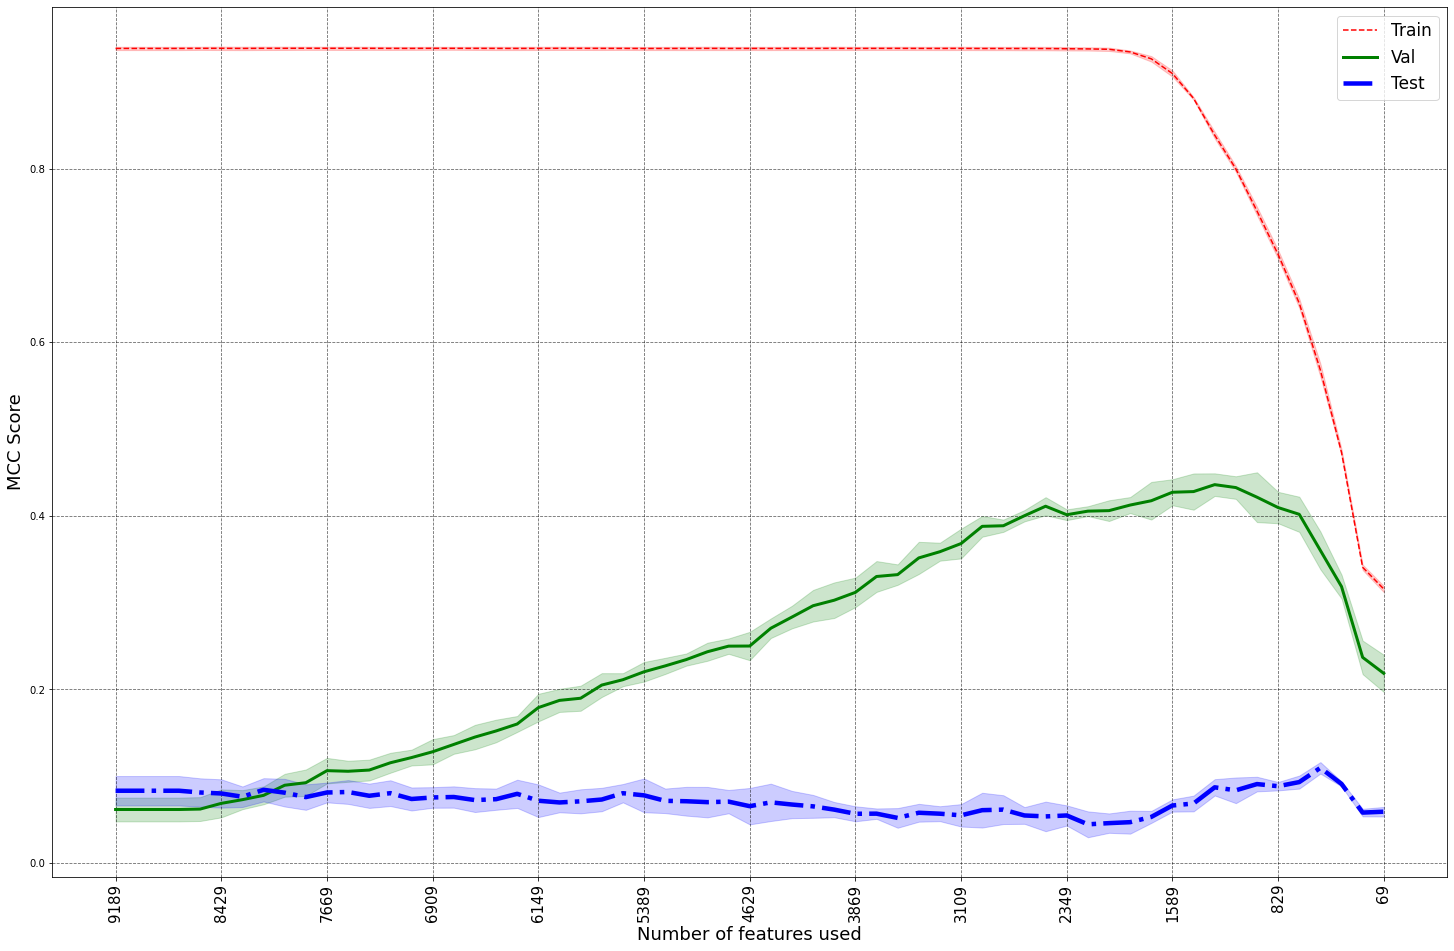

In [41]:
upper_bound_train = np.array(mean_scores_train) + np.array(std_scores_train)
lower_bound_train = np.array(mean_scores_train) - np.array(std_scores_train)
upper_bound_val = np.array(mean_scores_val) + np.array(std_scores_val)
lower_bound_val = np.array(mean_scores_val) - np.array(std_scores_val)
upper_bound_test = np.array(mean_scores_test) + np.array(std_scores_test)
lower_bound_test = np.array(mean_scores_test) - np.array(std_scores_test)


plt.figure(figsize=(25, 16))
plt.plot(mean_scores_train, label='Train', color='r', linewidth=1.5, linestyle='--')
plt.plot(mean_scores_val, label='Val', color='g', linewidth=3)
plt.plot(mean_scores_test, label='Test', color='b', linewidth=4.5, linestyle='-.')
plt.fill_between(range(0, np.unique(rfe.ranking_)[-1], 1), y1=lower_bound_train, y2=upper_bound_train, alpha=0.2, color='r')
plt.fill_between(range(0, np.unique(rfe.ranking_)[-1], 1), y1=lower_bound_val, y2=upper_bound_val, alpha=0.2, color='g')
plt.fill_between(range(0, np.unique(rfe.ranking_)[-1], 1), y1=lower_bound_test, y2=upper_bound_test, alpha=0.2, color='b')
plt.grid(alpha=0.6, color='k', linestyle='--')
plt.xticks(ticks=range(0, np.unique(rfe.ranking_)[-1], 5), labels=range(len(X_train.columns), 0, -760), rotation=90, fontsize=15)
plt.ylabel('MCC Score', fontsize=18)
plt.xlabel('Number of features used', fontsize=18)
plt.legend(fontsize=17)
plt.show()

From the above plot, it is evident that even though, as noted earlier, the performance on the validation dataset increases with the drop in the number of features, the performance on the test dataset remains consistently poor, from 9189 features all the way till only 300 features. This makes the problem of overfitting quite apparent in our case. 

Thus the several amino acid composition features do not impart valuable information for distinguishing the Il-5 inducing peptides(Positive dataset) from the IL-5 non-inducing peptides (Negative dataset).

## <font color='palevioletred'>CONCLUSION:</font>
**LogisticRegression** seems to be fairing the best out of all the models, however if we look at the overall picture, as predicted, the performance of all the models on the data seems to be quite poor.

The considerably large difference in the cross val scores and the test scores of the various models tells us that the models are overfitting to the training data, this can be possible only if the models are too complex, with lot of noise and a lack of signal in the data. It also happens when the dimensionality is too high.

Since even a simple model like LogisticRegression is overfitting and we have also reduced the number of dimensions using RFE, the only possible reason could be that the **various amino acid composition features, neither 9189 nor 1089 hold valuable information to enable differentiation of IL-5 inducing peptides (positive class) from the IL-5 non-inducing peptides (negative class)** and as a result, the model in order to get good results overfits on the noise in the data. This is also pretty evident from looking at the overlapping PCA distribution in a previous notebook. 

Hence using RFE for reducing the features is pointless since features are being dropped because they are deemed unimportant with respect to the training dataset alone and the RFE model retains only those features which give good results in the training data.Since these features dont actually bear information (retained only because they were giving good score on the training data), when they are used to distinguish positive and negative classes in the test data, it gives really bad performance.

A better bet probably might be to go for Dimensionality reduction via means of PCA which instead of dropping features, makes their linear combinations and compresses the dimensions (thus reducing them) while still managing to retain all the information.